# データシステムの知能化とデザイン
# 第8回課題
## 学籍番号：62116674
## 氏名：藤本巧実

## やるべきほうの課題(LSTMによる記事分類)

### データセットの作成

ライブラリのインポートとデータの取得

In [ ]:
from glob import glob
import pandas as pd
import linecache
import os
if not os.path.exists('text/topic-news/LICENSE.txt'):
  #!wget "https://drive.google.com/uc?export=download&id=15EvNnKB6Y6-jGpo1q6N5BZ8SqMI-xzze" -O ldcc-20140209.zip
  !wget https://keio.box.com/shared/static/agjdm4m93o5lay6k0uy9wfadqi79hwpm -O ldcc-20140209.zip
if not os.path.exists('text'):
  !unzip -q -P dataai ldcc-20140209.zip

--2023-12-14 02:52:20--  https://keio.box.com/shared/static/agjdm4m93o5lay6k0uy9wfadqi79hwpm
Resolving keio.box.com (keio.box.com)... 74.112.186.144
Connecting to keio.box.com (keio.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/agjdm4m93o5lay6k0uy9wfadqi79hwpm [following]
--2023-12-14 02:52:20--  https://keio.box.com/public/static/agjdm4m93o5lay6k0uy9wfadqi79hwpm
Reusing existing connection to keio.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://keio.app.box.com/public/static/agjdm4m93o5lay6k0uy9wfadqi79hwpm [following]
--2023-12-14 02:52:21--  https://keio.app.box.com/public/static/agjdm4m93o5lay6k0uy9wfadqi79hwpm
Resolving keio.app.box.com (keio.app.box.com)... 74.112.186.144
Connecting to keio.app.box.com (keio.app.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://public.boxcloud.com/d/1/b1!DRyqc

タイトル記事名の取得

In [ ]:
categories = [name for name in os.listdir('./text') if os.path.isdir("./text/" +name)]
print(categories)

['it-life-hack', 'dokujo-tsushin', 'kaden-channel', 'movie-enter', 'livedoor-homme', 'topic-news', 'smax', 'sports-watch', 'peachy']


タイトルとカテゴリのセットを作成・表示

In [ ]:
xs = []
for catdir in categories:
  path = "./text/" + catdir + "/*.txt"
  files = glob(path)
  for text_name in files:
    title = linecache.getline(text_name, 3)
    xs.append([title, catdir])
ldccdatasets = pd.DataFrame(xs, columns=["title", "category"])
ldccdatasets

,title,category
0,なんだ、そうだったのか！Googleロゴが四角い建築である理由\n,it-life-hack
1,電子ブックリーダー「kobo Touch」の実機が見られる！楽天が大手書店と連携した理由\n,it-life-hack
2,ついに本日、発売開始！パナソニック、最強カスタマイズの「レッツノートSX1」開封レポート\n,it-life-hack
3,Wordで何行書いたかひと目でわかるようにする方法【知っ得・虎の巻】\n,it-life-hack
4,話題の最新スマホの予約日が決定！ドコモ、MEDIAS X N-07Dを発売へ\n,it-life-hack
...,...,...
7371,向井理さんの「今の時間帯だと言えない」ヒミツ\n,peachy
7372,【終了しました】600万個突破！「クレンジングリサーチ ソープ＆ソープｂ」をセットで20名様...,peachy
7373,あなたの見た目年齢を上げているのは“シミ”だった？ 今こそ本気で美白対策！ \n,peachy
7374,友近千鶴の運命相談\n,peachy


しっかりシャッフル・型の確認

In [ ]:
# データフレームシャッフル
datasets = ldccdatasets.sample(frac=1, random_state=12).reset_index(drop=True)
datasets.head()
datasets.shape

(7376, 2)

### 形態素解析(言語をネットワークに入力する)

mecabのインストール

In [ ]:
!apt install -y --quiet mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file
!pip install -q mecab-python3
!ln -s /etc/mecabrc /usr/local/etc/mecabrc

Reading package lists...
Building dependency tree...
Reading state information...
make is already the newest version (4.3-4.1build1).
make set to manually installed.
xz-utils is already the newest version (5.2.5-2ubuntu1).
xz-utils set to manually installed.
curl is already the newest version (7.81.0-1ubuntu1.15).
file is already the newest version (1:5.41-3ubuntu0.1).
git is already the newest version (1:2.34.1-1ubuntu1.10).
The following additional packages will be installed:
  libmecab2 mecab-ipadic mecab-utils
The following NEW packages will be installed:
  libmecab-dev libmecab2 mecab mecab-ipadic mecab-ipadic-utf8 mecab-utils
0 upgraded, 6 newly installed, 0 to remove and 23 not upgraded.
Need to get 7,367 kB of archives.
After this operation, 59.3 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libmecab2 amd64 0.996-14build9 [199 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libmecab-dev amd64 0.996-14build9 [306 kB

確認

In [ ]:
!echo すもももももももものうち。 | mecab

すもも	名詞,一般,*,*,*,*,すもも,スモモ,スモモ
も	助詞,係助詞,*,*,*,*,も,モ,モ
もも	名詞,一般,*,*,*,*,もも,モモ,モモ
も	助詞,係助詞,*,*,*,*,も,モ,モ
もも	名詞,一般,*,*,*,*,もも,モモ,モモ
の	助詞,連体化,*,*,*,*,の,ノ,ノ
うち	名詞,非自立,副詞可能,*,*,*,うち,ウチ,ウチ
。	記号,句点,*,*,*,*,。,。,。
EOS


ライブラリのインポートとwakatiリストの定義

In [ ]:
import MeCab
import re

tagger = MeCab.Tagger("-Owakati")

def make_wakati(sentence):
  sentence = tagger.parse(sentence)
  sentence = re.sub(r'[0-9０-９a-zA-Zａ-ｚＡ-Ｚ]+', " ", sentence)
  sentence = re.sub(r'[\．_－―─！＠＃＄％＾＆\-‐|\\＊\“（）＿■×+α※÷⇒—●★☆〇◎◆▼◇△□(：〜～＋=)／*&^%$#@!~`){}［］…\[\]\"\'\”\’:;<>?＜＞〔〕〈〉？、。・,\./『』【】「」→←○《》≪≫\n\u3000]+', "", sentence)
  wakati = sentence.split(" ")
  wakati = list(filter(("").__ne__, wakati))
  return wakati

単語から番号を得るword2indexを作成

In [ ]:
word2index = {}
# 系列を揃えるためのパディング文字列<pad>を追加
# パディング文字列のIDは0とする
word2index.update({"<pad>":0})

for title in datasets["title"]:
  wakati = make_wakati(title)
  for word in wakati:
    if word in word2index: continue
    word2index[word] = len(word2index)
print("datasets vocab size : ", len(word2index))

datasets vocab size :  13230


確認

In [ ]:
word2index['クリスマス']

560

### サポート関数の定義

ライブラリのインポートと定義

In [ ]:
from sklearn.model_selection import train_test_split
import random
from sklearn.utils import shuffle

cat2index = {}
for cat in categories:
  if cat in cat2index: continue
  cat2index[cat] = len(cat2index)

def sentence2index(sentence):
  wakati = make_wakati(sentence)
  return [word2index[w] for w in wakati]

タイトル文章を単語IDの配列に変換

In [ ]:
idx_title_raw = []
idx_category = []

# 系列の長さの最大値を取得する
max_len = 0
for title, category in zip(datasets["title"], datasets["category"]):
  idxtitle = sentence2index(title) # タイトルを文字ID列に変換
  idxcategory = [cat2index[category]] # カテゴリ名をカテゴリIDに変換し2次元配列にする
  idx_title_raw.append(idxtitle) # タイトルの文字ID列をそのまま追加
  idx_category.append(idxcategory) #カテゴリIDを追加
  if max_len < len(idxtitle): # 最大長さを取得
    max_len = len(idxtitle)

# 短い系列に対してパディングを追加し系列の長さをmax_len揃える
idx_title = []
for title in idx_title_raw:
  for i in range(max_len - len(title)):
#    title.insert(0, 0) # 前パディング
    title.append(0) # 後ろパディング
  idx_title.append(title)

### データローダの定義

ライブラリのインポートと定義

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
class MyDataset(Dataset):
    def __init__(self):
      super().__init__()

    def __len__(self):
        return len(idx_title)

    def __getitem__(self, idx):
        title = torch.LongTensor(idx_title[idx])
        category = torch.LongTensor(idx_category[idx])
        return title, category

インスタンス化

In [ ]:
mydataset = MyDataset()

確認

In [ ]:
mydataset[4], datasets["title"][4], word2index['猫']

((tensor([53, 54,  4, 55, 56, 57,  2, 58, 59,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0]),
  tensor([5])),
 'ＡＫＢ大島優子に非難殺到 「性格が悪すぎる」\n',
 2400)

学習用と検証用のデータセットを作成

In [ ]:
train_dataset, valid_dataset = torch.utils.data.random_split(
    mydataset,
    [int(len(mydataset)*0.7), len(mydataset)-int(len(mydataset)*0.7)]
)

学習用と評価用のデータローダを定義

In [ ]:
BATCH_SIZE = 100
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    drop_last=True,
    pin_memory=True
)

valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=len(valid_dataset),
    shuffle=False
)

検証用データの確認

In [ ]:
next(iter(train_dataloader))
next(iter(valid_dataloader))[0].shape

torch.Size([2213, 39])

### ネットワークの定義

**LSTM**のネットワークを定義

In [ ]:
class LSTMClassifier(nn.Module):
  def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
    super(LSTMClassifier, self).__init__()
    self.hidden_dim = hidden_dim
    self.word_embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
    self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
    self.fc = nn.Linear(hidden_dim, tagset_size)

  def forward(self, sentence):
    embeds = self.word_embeddings(sentence)
    _, lstm_out = self.lstm(embeds)
    tag_space = self.fc(lstm_out[0])
    return tag_space

### ネットワークの構築，ハイパーパラメータ・ロス関数・最適化関数の設定

In [ ]:
cuda = "cuda:0"
device = torch.device(cuda if torch.cuda.is_available() else "cpu")

EMBEDDING_DIM = 200
HIDDEN_DIM = 128
VOCAB_SIZE = len(word2index)
TAG_SIZE = len(categories)
EPOCH = 100
model = LSTMClassifier(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE, TAG_SIZE).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### 学習と検証

In [ ]:
losses = []
losshist = []
acchist = []
for epoch in range(EPOCH):
  all_loss = 0
  model.train()
  for title, catgory in train_dataloader:
    model.zero_grad()
    title_tensor = title.to(device)
    category_tensor = catgory.to(device)
    out = model(title_tensor)
    batch_loss = loss_function(out.squeeze(), category_tensor.reshape(-1))
    batch_loss.backward()
    optimizer.step()
    all_loss += batch_loss.item()
  print("epoch", epoch, "\n" , "loss", all_loss)
  losshist.append(all_loss)

  model.eval()
  with torch.no_grad():
    for title, catgory in valid_dataloader:
      title_tensor = title.to(device)
      category_tensor = catgory.to(device).squeeze()
      out = model(title_tensor)
      _, preds = torch.max(out, 2)
  acc = ((preds == category_tensor).sum() / len(preds.reshape(-1))).cpu().numpy().copy()
  print("accuracy : ", acc)
  acchist.append(acc)
  if all_loss < 1: break
print("done.")

epoch 0 
 loss 111.6262857913971
accuracy :  0.10257569
epoch 1 
 loss 111.5198974609375
accuracy :  0.10483506
epoch 2 
 loss 106.54406332969666
accuracy :  0.22096701
epoch 3 
 loss 101.54603779315948
accuracy :  0.19972886
epoch 4 
 loss 98.27247655391693
accuracy :  0.21870764
epoch 5 
 loss 91.50966799259186
accuracy :  0.29326704
epoch 6 
 loss 79.65087294578552
accuracy :  0.36827835
epoch 7 
 loss 71.25637483596802
accuracy :  0.38138273
epoch 8 
 loss 68.79096901416779
accuracy :  0.44826028
epoch 9 
 loss 63.263771533966064
accuracy :  0.4532309
epoch 10 
 loss 58.10863423347473
accuracy :  0.45006776
epoch 11 
 loss 54.109259724617004
accuracy :  0.47220966
epoch 12 
 loss 49.8237566947937
accuracy :  0.51649344
epoch 13 
 loss 41.8763524889946
accuracy :  0.54722095
epoch 14 
 loss 38.72339969873428
accuracy :  0.53727967
epoch 15 
 loss 35.33731797337532
accuracy :  0.55987346
epoch 16 
 loss 30.12907338142395
accuracy :  0.57794845
epoch 17 
 loss 27.21379166841507
accura

###結果の描画

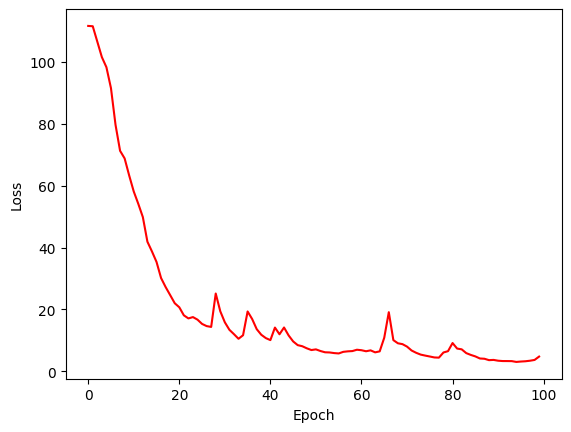

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.arange(len(losshist)), losshist, 'r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

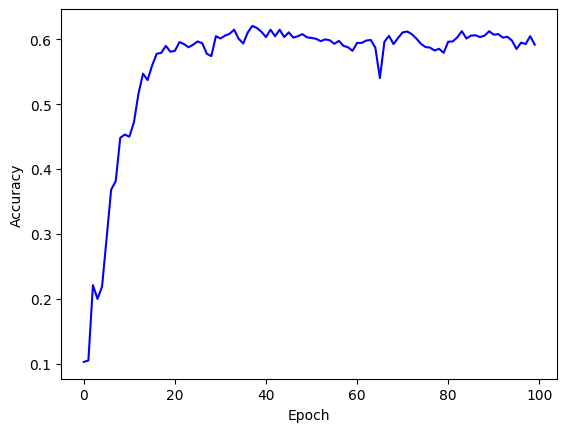

In [ ]:
plt.plot(np.arange(len(acchist)), acchist , 'b')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show

### 結果の考察

記事の判定の詳細を確認

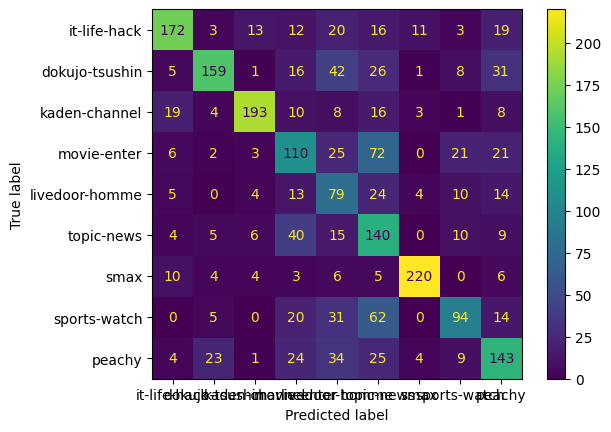

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
rescat = category_tensor.cpu().numpy().copy()
respreds = preds.cpu().squeeze().numpy().copy()

cm = confusion_matrix(rescat, respreds)
cm

disp =ConfusionMatrixDisplay(confusion_matrix=cm,
  display_labels=categories)
disp.plot()
plt.show()

## どっちでもよかった課題(株価予想)

ライブラリのインポート

In [ ]:
cuda = "cuda:0"
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import urllib.request
import time
import codecs
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(1)

株価の取得

In [ ]:
def getstockfromweb():
  page_num = 20 # 取得するページ数
  tstock = []
  for i in range(page_num):
    # Yahoo Financeのページを利用
    url = "https://finance.yahoo.co.jp/quote/998407.O/history?from=20170101&to=20211231&timeFrame=d&page=" + str(i+2)
    html = urllib.request.urlopen(url)
    soup = BeautifulSoup(html, "lxml")
    estock = [value.get_text() for value in soup.find_all("td")[0:100]]
     #<td></td>に欲しい数値が文字で入っているのでその部分を抽出し、get_textで文字のみさらに抽出する
    tstock.extend(estock) # appendではなく一つの大きな配列にするためextendを使う
    time.sleep(0.1) # どんどんデータをとると、サーバが察知してデータが取れなくなる
  tstock = np.array(tstock) # NumPyへ変換
  stock = tstock.reshape(-1, 5)
  stock = pd.DataFrame(stock, columns=['date', 'open', 'max', 'min', 'close'], index=stock[:,0])
  stock = stock.drop('date',axis=1).apply(lambda x: x.str.replace(',','')).apply(lambda x: x.astype(np.float32))
  return stock
#  return stock.apply(lambda x: x.str.replace(',','')).astype(np.float32) # 文字を数字に変換
# この関数の実行を確認する場合は、次のコードセルを作成して実行するとよい
# stock = getstockfromweb()
# stock

In [ ]:
def getstockdata():
  path = 'stockdata.csv'
  with codecs.open(path, "r", "Shift-JIS", "ignore") as f:
    stock = pd.read_table(f, delimiter=",", header=None, names=['date', 'open', 'max', 'min', 'close', 'total', 'adjustment'])
    stock = stock.drop(stock.index[[0,1]])[['open', 'max', 'min', 'close', 'total', 'adjustment']].apply(lambda x: x.astype(np.float32))
  return stock

In [ ]:
whichdata = False # webスクレイピングを利用する、Falseでダウンロードデータを利用する
if whichdata==True:
  dfp = getstockfromweb()
  print(dfp.dtypes)
  print(dfp)
  df = dfp.reset_index(drop=True).drop(columns=['open', 'max', 'min'])
else:
  import os
  if not os.path.exists('stockdata.csv'):
      #!wget "https://drive.google.com/uc?export=download&id=1OsqF2vQ94ZF8gA0IEjhp0rJM-2lnyfUw" -O stockdata.csv
      !wget https://keio.box.com/shared/static/xml20yn9im6xiytxe5z25wbja242g61k -O stockdata.csv
  dfp = getstockdata()
  print(dfp.dtypes)
  print(dfp)
  df = dfp.reset_index(drop=True).drop(columns=['open','max','min','total','adjustment'])
df

--2023-12-12 08:22:22--  https://keio.box.com/shared/static/xml20yn9im6xiytxe5z25wbja242g61k
Resolving keio.box.com (keio.box.com)... 74.112.186.144
Connecting to keio.box.com (keio.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/xml20yn9im6xiytxe5z25wbja242g61k [following]
--2023-12-12 08:22:22--  https://keio.box.com/public/static/xml20yn9im6xiytxe5z25wbja242g61k
Reusing existing connection to keio.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://keio.app.box.com/public/static/xml20yn9im6xiytxe5z25wbja242g61k [following]
--2023-12-12 08:22:22--  https://keio.app.box.com/public/static/xml20yn9im6xiytxe5z25wbja242g61k
Resolving keio.app.box.com (keio.app.box.com)... 74.112.186.144
Connecting to keio.app.box.com (keio.app.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://public.boxcloud.com/d/1/b1!THpeG

,close
0,2690.0
1,2750.0
2,2711.0
3,2749.0
4,2755.0
...,...
148,2276.0
149,2255.0
150,2228.0
151,2271.0


学習用データを作成
- 正規化をして精度を上げる

In [ ]:
#訓練データとテストデータに分割
test_size = 0.3
sp = df['close'].values # pandasからnumpyへ変換
total_len = len(sp)
test_len = int(len(sp)*test_size)
train_len = total_len - test_len
print("total_len:", total_len, " train_len:", train_len, "test_len:", test_len)
train = sp[0:train_len]
test = sp[train_len:total_len]
x_max, x_min = max(sp), min(sp)
train_norm = (train - x_min) / (x_max - x_min) # 正規化
test_norm = (test - x_min) / (x_max - x_min) # 正規化

total_len: 153  train_len: 108 test_len: 45


データを分割

In [ ]:
#時系列データに分割
n_time = 6
x_train, y_train, x_test, y_test= [], [], [], []
for i in range(train_len-n_time):
  x_train.append(train_norm[i:i+n_time].reshape(-1,1))
  y_train.append(train_norm[i+n_time])
for i in range(test_len-n_time):
  x_test.append(test_norm[i:i+n_time])
  y_test.append(test_norm[i+n_time])

作成したデータをTensorDatasetとしてDataLoaderに渡す

In [ ]:
epochs = 50
batch_size = 32
train_input_data = torch.tensor(x_train, dtype=torch.float)  # テンソルに変換
train_correct_data = torch.tensor(y_train, dtype=torch.float)
train_dataset = torch.utils.data.TensorDataset(train_input_data, train_correct_data)  # trainデータセットの作成
train_loader = DataLoader(train_dataset, batch_size=batch_size)

test_input_data = torch.tensor(x_test, dtype=torch.float)  # テンソルに変換
test_correct_data = torch.tensor(y_test, dtype=torch.float)
test_dataset = torch.utils.data.TensorDataset(test_input_data, test_correct_data)  # testデータセットの作成
test_loader = DataLoader(test_dataset, batch_size=len(x_test))

device = torch.device(cuda if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


<ipython-input-7-a05a55699403>:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  train_input_data = torch.tensor(x_train, dtype=torch.float)  # テンソルに変換


損失関数の計算の定義

In [ ]:
def learn():
  loss_func = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
  record_loss_train = []
  model.train()
  time_sta = time.perf_counter()
  for i in range(epochs):
    for j, (x, t) in enumerate(train_loader):
      x, t = x.to(device), t.reshape(-1,1).to(device)
      y = model(x)
      loss = loss_func(y, t)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    loss /= j+1
    record_loss_train.append(loss.item()) # 勾配情報を消す・lossの計算結果をGPUからCPUに移すためにloss→loss.item()
    print(f'epoch: {i:3} loss: {loss.item():10.8f}')
  plt.plot(range(len(record_loss_train)), record_loss_train, label="Train")
  plt.legend()
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.show()
  time_end = time.perf_counter()
  print("Elapsed Time:",  time_end- time_sta)
  return record_loss_train

In [ ]:
def show(record_loss_train):
  sp_norm = sp/x_max
  in_true = list(sp_norm.reshape(-1).astype(np.float32)) # ここの意味を理解する
  pred = []
  model.eval()
  for i in range(n_time):
    pred.append(0)
  with torch.no_grad():
    for i in range(len(sp)-n_time):
      x = torch.tensor(in_true[i:i+n_time])  # 直近の時系列を取り出す
      x = x.reshape(1, -1, 1)  # (バッチサイズ, 時系列の数, 入力の数)
      y = model(x)
      pred.append(y[0].item())  # 予測結果をpredictedに追加する
  plt.plot(range(len(sp)), sp, label="Correct")
  pred = np.array(pred)
  pred = pred * x_max
  plt.plot(range(len(pred)), pred, label="Predicted")
  plt.legend()
  plt.show()

ここの意味を理解する→CPUはFP64・GPUはFP32のため，GPUにCPUが扱えるFP64を入れると桁あふれによりエラーになる．つまり，`.astype(np.float32)`によってCPUをFP32に変換してからGPUに入れるようにする．

### ①GRUを用いた評価

In [ ]:
class GRUN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(GRUN, self).__init__()
    self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)
  def forward(self, x):
    x = x.to(device)
    y_gru, h = self.gru(x, None)
    y = self.fc(y_gru[:, -1, :])
    return y
model = GRUN(1, 100, 1).to(device)
print(model)

GRUN(
  (gru): GRU(1, 100, batch_first=True)
  (fc): Linear(in_features=100, out_features=1, bias=True)
)


結果の表示

epoch:   0 loss: 0.00967935
epoch:   1 loss: 0.00280316
epoch:   2 loss: 0.00451574
epoch:   3 loss: 0.00312620
epoch:   4 loss: 0.00327820
epoch:   5 loss: 0.00317253
epoch:   6 loss: 0.00380984
epoch:   7 loss: 0.00188703
epoch:   8 loss: 0.00322448
epoch:   9 loss: 0.00181429
epoch:  10 loss: 0.00336591
epoch:  11 loss: 0.00148389
epoch:  12 loss: 0.00350043
epoch:  13 loss: 0.00116995
epoch:  14 loss: 0.00380802
epoch:  15 loss: 0.00111535
epoch:  16 loss: 0.00505430
epoch:  17 loss: 0.00144987
epoch:  18 loss: 0.00570019
epoch:  19 loss: 0.00111853
epoch:  20 loss: 0.00194127
epoch:  21 loss: 0.00167483
epoch:  22 loss: 0.00076093
epoch:  23 loss: 0.00187043
epoch:  24 loss: 0.00079760
epoch:  25 loss: 0.00085599
epoch:  26 loss: 0.00116590
epoch:  27 loss: 0.00068414
epoch:  28 loss: 0.00100962
epoch:  29 loss: 0.00079887
epoch:  30 loss: 0.00076069
epoch:  31 loss: 0.00088649
epoch:  32 loss: 0.00069236
epoch:  33 loss: 0.00079176
epoch:  34 loss: 0.00069998
epoch:  35 loss: 0.0

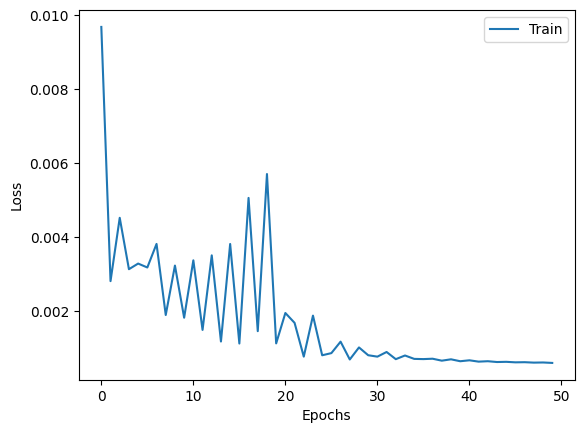

Elapsed Time: 1.8662660610000046


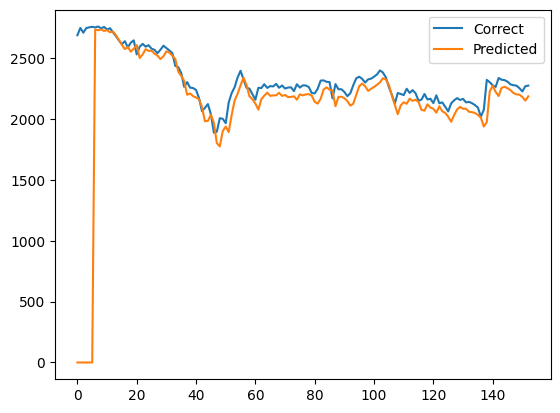

In [ ]:
result = learn()
show(learn)

In [ ]:
gruloss = result[-1]

### ②RNNを用いた評価

In [ ]:
class RNNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(RNNN, self).__init__()
    self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)
  def forward(self, x):
    x = x.to(device)
    y_rnn, h = self.rnn(x, None)
    y = self.fc(y_rnn[:, -1, :])
    return y
model = RNNN(1, 100, 1).to(device)
print(model)

RNNN(
  (rnn): RNN(1, 100, batch_first=True)
  (fc): Linear(in_features=100, out_features=1, bias=True)
)


結果の表示

epoch:   0 loss: 0.00589037
epoch:   1 loss: 0.01667315
epoch:   2 loss: 0.00251657
epoch:   3 loss: 0.00739300
epoch:   4 loss: 0.01625605
epoch:   5 loss: 0.00872826
epoch:   6 loss: 0.00424668
epoch:   7 loss: 0.00511249
epoch:   8 loss: 0.00236792
epoch:   9 loss: 0.00666610
epoch:  10 loss: 0.00243030
epoch:  11 loss: 0.00494354
epoch:  12 loss: 0.00234172
epoch:  13 loss: 0.00324073
epoch:  14 loss: 0.00325608
epoch:  15 loss: 0.00236026
epoch:  16 loss: 0.00331436
epoch:  17 loss: 0.00232992
epoch:  18 loss: 0.00278511
epoch:  19 loss: 0.00234769
epoch:  20 loss: 0.00250460
epoch:  21 loss: 0.00234621
epoch:  22 loss: 0.00234229
epoch:  23 loss: 0.00229450
epoch:  24 loss: 0.00221077
epoch:  25 loss: 0.00220311
epoch:  26 loss: 0.00209026
epoch:  27 loss: 0.00213123
epoch:  28 loss: 0.00198689
epoch:  29 loss: 0.00209642
epoch:  30 loss: 0.00186709
epoch:  31 loss: 0.00208270
epoch:  32 loss: 0.00170160
epoch:  33 loss: 0.00211647
epoch:  34 loss: 0.00149151
epoch:  35 loss: 0.0

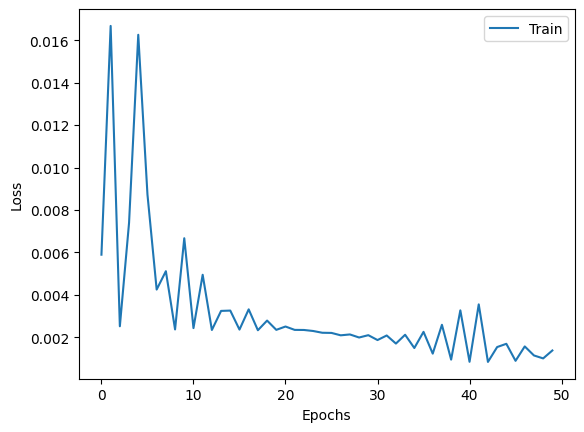

Elapsed Time: 0.6568756279999945


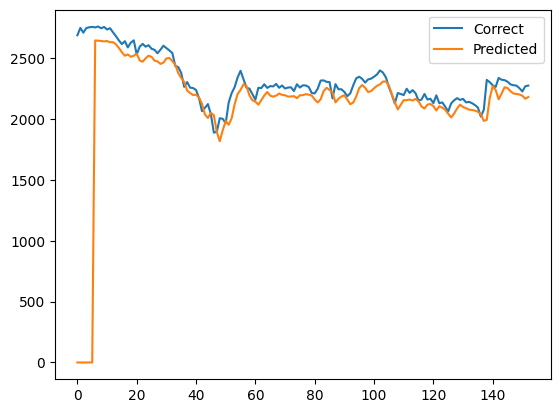

In [ ]:
result = learn()
show(learn)

In [ ]:
rnnloss = result[-1]

### ③LSTMを用いた評価

In [ ]:
class LSTMN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(LSTMN, self).__init__()
    self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)
  def forward(self, x):
    x = x.to(device)
    y_lstm, h = self.lstm(x, None)
    y = self.fc(y_lstm[:, -1, :])
    return y
model = LSTMN(1, 100, 1).to(device)
print(model)

LSTMN(
  (lstm): LSTM(1, 100, batch_first=True)
  (fc): Linear(in_features=100, out_features=1, bias=True)
)


結果の表示

epoch:   0 loss: 0.01997105
epoch:   1 loss: 0.00286675
epoch:   2 loss: 0.00691755
epoch:   3 loss: 0.00293189
epoch:   4 loss: 0.00439069
epoch:   5 loss: 0.00377337
epoch:   6 loss: 0.00351674
epoch:   7 loss: 0.00335659
epoch:   8 loss: 0.00271188
epoch:   9 loss: 0.00259359
epoch:  10 loss: 0.00477950
epoch:  11 loss: 0.00247900
epoch:  12 loss: 0.00654814
epoch:  13 loss: 0.00345058
epoch:  14 loss: 0.01215617
epoch:  15 loss: 0.00825367
epoch:  16 loss: 0.00439221
epoch:  17 loss: 0.00404151
epoch:  18 loss: 0.00227468
epoch:  19 loss: 0.00360220
epoch:  20 loss: 0.00424115
epoch:  21 loss: 0.00221878
epoch:  22 loss: 0.00296104
epoch:  23 loss: 0.00247418
epoch:  24 loss: 0.00213170
epoch:  25 loss: 0.00236105
epoch:  26 loss: 0.00200231
epoch:  27 loss: 0.00291579
epoch:  28 loss: 0.00204871
epoch:  29 loss: 0.00316141
epoch:  30 loss: 0.00190719
epoch:  31 loss: 0.00226285
epoch:  32 loss: 0.00264015
epoch:  33 loss: 0.00183926
epoch:  34 loss: 0.00245471
epoch:  35 loss: 0.0

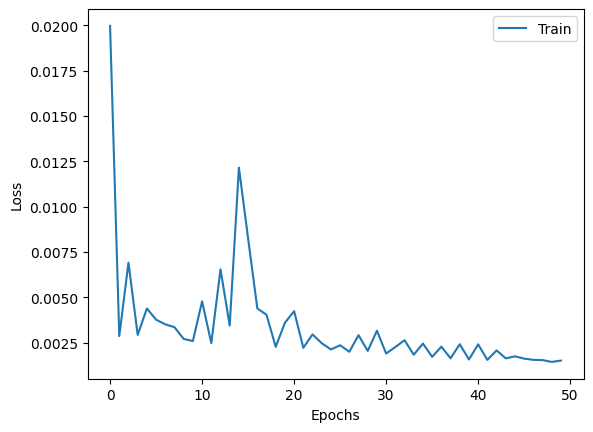

Elapsed Time: 0.8185873810000146


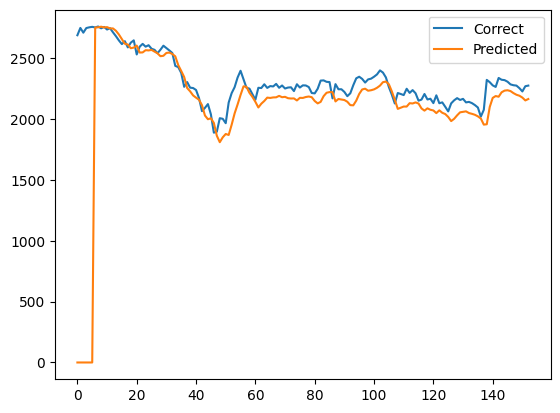

In [ ]:
result = learn()
show(learn)

In [ ]:
lstmloss = result[-1]

### MSELossの値の比較

In [ ]:
print("GRU:", gruloss)
print("RNN:", rnnloss)
print("LSTM:", lstmloss)

GRU: 0.0005908488528802991
RNN: 0.0013755690306425095
LSTM: 0.0015167280798777938


| |LOSS|Elapsed Time|
|---|---|---|
|GRU|0.0005908488528802991|1.8662660610000046|
|RNN|0.0013755690306425095|0.6568756279999945|
|LSTM|0.0015167280798777938|0.8185873810000146|

### 結果・考察

まず初めに，３種類にのネットワークモデルを比較する．

- RNN：PyTorchの再帰型ニューラルネットワーク(オワコン？)

- LSTM：長期的な依存関係の学習・記憶保持に適している．勾配消失問題を緩和する．

- GRU：LSTMに比してシンプルな構造で計算量が少ない

結果を見てみると，最終的なロスはGRUが最も小さく，LSTMが最も大きい．GRUは10～20エポックにおいて大きく振動したあとに収束している．RNNは0～5エポックで大きく振動し，その後収束しながらもやや振動的である．LSTMは大きな振動は見られないが，14エポック目でステップ的な応答を示している．また計算スピードについては，RNNがLSTMと僅差で最も速く，GRUが最も遅い．

これらの結果を鑑みると，それぞれの特徴にあった結果を得られていないことがわかる．

考察①：株価に周期性はほぼみられていないため，LSTMは過去の記憶セルの参照がうまくできなかった．したがって，ロスが最も大きくなったしまった

考察②：RNNはロスが収束しきっておらず，値の信頼度が低い．安定的な学習ができていないことは最終的な結果に影響する．

考察③：ロスに関しては３つとも極めて小さいため，正直なところどれも差は無い．計算時間も１秒程度の差である．

## 発展的課題(全結合網のみを用いた実装)

コード

In [ ]:
class NET(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(NET, self).__init__()
    # self.NET = nn.NET(input_size, hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)
  def forward(self, x):
    x = x.to(device)
    # y_NET, h = self.NET(x, None)
    y = self.fc(x)
    return y
model = NET(1, 100, 1).to(device)
print(model)

NET(
  (fc): Linear(in_features=100, out_features=1, bias=True)
)
